# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Plot initial findings
4. Calculate skill percentage
5. Plot final findings

#### Original Exploration
[13_Matplotlib_Format_Charts.ipynb](../2_Advanced/12_Exercise_Trending_Skills.ipynb)

### Import Libraries and Data

In [2]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [3]:
# Setting what role and which country to explore
role = 'Data Analyst'
country = 'Hungary'

### Filter the Data for the Country

In [4]:
df_country = df[df['job_country'] == country].copy()

### Explode Skills

This expands the lists in the `job_skills` column in a way that each skill in the lists will appear in its own row.

In [8]:
df_skills = df_country.explode('job_skills')

df_skills[['job_title_short', 'job_skills']]

,job_title_short,job_skills
72,Software Engineer,power bi
443,Data Engineer,sql
443,Data Engineer,sharepoint
999,Software Engineer,sap
1326,Data Engineer,sql
...,...,...
785579,Data Engineer,sql
785579,Data Engineer,sql server
785579,Data Engineer,azure
785579,Data Engineer,power bi


### Count the Skills per Job Title

This groups our DataFrame by `job_skills` and `job_title_short` while counting the occurrences of each skill in each job title. Then it turns the result into a DataFrame and, at the same time, renames the resulting series with the counting values to 'skill_count'. Finally, it sorts the new DataFrame by the `skill_count` column in descending order so that the most common skill-job title combinations appear first.

In [9]:
# Grouping the data and counting skill occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Turning the result into a DataFrame and renaming the series
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sorting by the count values
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

# Display
df_skills_count

,job_skills,job_title_short,skill_count
610,python,Data Engineer,334
780,sql,Data Engineer,327
779,sql,Data Analyst,306
198,excel,Data Analyst,264
609,python,Data Analyst,195
...,...,...,...
417,macos,Data Scientist,1
416,macos,Cloud Engineer,1
737,snowflake,Cloud Engineer,1
414,looker,Senior Data Scientist,1


### Get the Top 3 Roles

In [10]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

### Plot Skill Counts

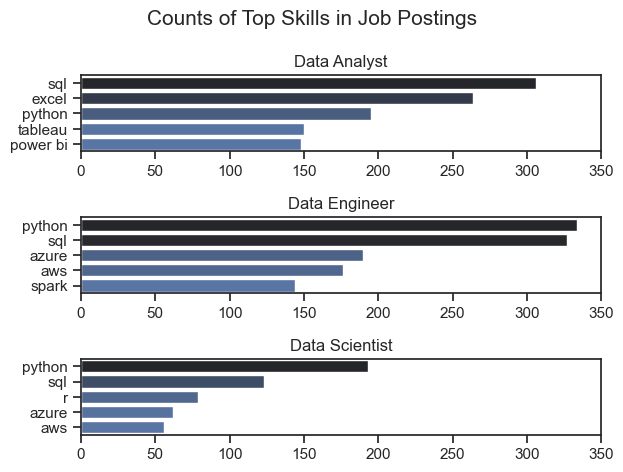

In [28]:
xlim = (int(df_skills_count['skill_count'].iloc[0]/10)+2)*10

fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend().remove()
    ax[i].set_xlim(0, xlim)

fig.suptitle('Counts of Top Skills in Job Postings', fontsize=15)
plt.tight_layout()
plt.show()

### Convert These Counts to Percentages

#### Problem: Counts don't show what portions of jobs are requesting these skills

We need the percentages for that. Before we can calculate those, we need the total counts of jobs posted in each job title.

In [29]:
df_job_title_count = df_country['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,639
1,Data Engineer,518
2,Data Scientist,309
3,Business Analyst,236
4,Software Engineer,228
5,Senior Data Engineer,168
6,Machine Learning Engineer,93
7,Senior Data Scientist,69
8,Senior Data Analyst,69
9,Cloud Engineer,58


Now, we can calculate the percentages and add them to our existing DataFrame using `pd.merge()`.

In [30]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short')

df_skills_perc['skill_percent'] = df_skills_perc['skill_count'] / df_skills_perc['jobs_total'] * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Engineer,334,518,64.478764
1,sql,Data Engineer,327,518,63.127413
2,sql,Data Analyst,306,639,47.887324
3,excel,Data Analyst,264,639,41.314554
4,python,Data Analyst,195,639,30.516432
...,...,...,...,...,...
907,macos,Data Scientist,1,309,0.323625
908,macos,Cloud Engineer,1,58,1.724138
909,snowflake,Cloud Engineer,1,58,1.724138
910,looker,Senior Data Scientist,1,69,1.449275


### Plot Percentages

Let's now see what the likelihoods are of the top 5 skills appearing in postings for the top 3 job titles.

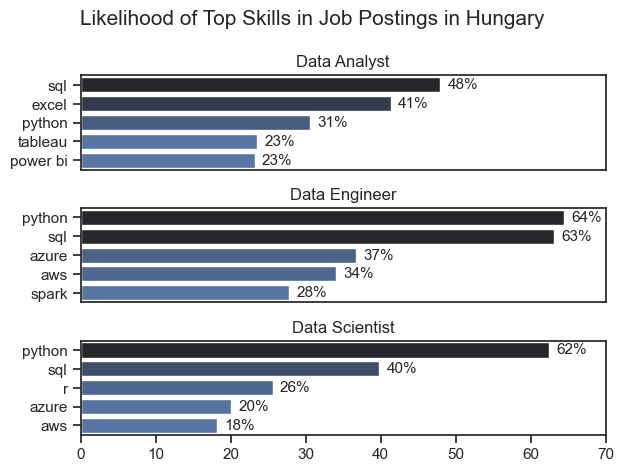

In [38]:
xlim = (int((df_skills_perc['skill_percent'].iloc[0])/10)+1)*10

fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_percent', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].legend().set_visible(False)
    ax[i].set_xlim(0, xlim)
    
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v+1, n, f'{v:.0f}%', va='center', fontsize=11)
    
fig.suptitle(f'Likelihood of Top Skills in Job Postings in {country}', fontsize=15)
plt.tight_layout()
plt.show()